<a href="https://colab.research.google.com/github/vitfrncs/LiPAI_board/blob/master/src/semana_8/semana8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SEMANA 8 - Redes Neurais Convolucionais

#### QUESTAO 1

Defina uma variável device no início do código e use o método .to(device) para enviar o modelo e cada lote de tensores (imagens e rótulos) para a GPU durante o loop de treinamento e avaliação.

As linhas modificadas para atingir o objetivo do enunciado possuem o comentário "QUESTAO 1".

In [60]:
import torch

import torchvision
from torchvision import transforms

# QUESTAO 1:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Treinando em: {device}")

# MNIST dataset
root_path = '/home/storopoli/Downloads' # mude isso no Colab se necessário

# Pequena transformação para tensores e normalizando o tamanho
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Train/Test Datasets
train_dataset = torchvision.datasets.MNIST(root=root_path, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=root_path, train=False, transform=trans)

Treinando em: cuda


In [61]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/storopoli/Downloads
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [62]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/storopoli/Downloads
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

#### QUESTÃO 2:  
Divida o train_dataset original em conjuntos de treino e validação usando torch.utils.data.random_split. Em seguida, adicione um loop de validação (com model.eval() e torch.no_grad()) dentro do loop de épocas para calcular a perda e a acurácia de validação.

In [63]:
from torch.utils.data import random_split, DataLoader
batch_size=32

train_size = int(0.8 * len(train_dataset)) # pegamos 80% do train_dataset para treino
val_size = len(train_dataset) - train_size # restante do train_dataset que será usando para validação

# dividindo o train_dataset em dois subconjuntos aleátorios
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

#itera sobre o conjunto de treino:
train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)

# não precisa embaralhar pois a validação não altera pesos, só avalia eles :)
val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [64]:
import torch.nn as nn

In [65]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU())
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Instancia o Model()
model = ConvNet().to(device)  # <- move o modelo para GPU  - QUESTAO 1

print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [66]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

3199106

In [67]:
from torch.optim import Adam

# Hiperparâmetros
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 6

# Instânciar o Otimizador Adam
optimizer = Adam(model.parameters(), lr=learning_rate)

In [68]:
# Isto tem que retornar True
import torch
torch.cuda.is_available()

True

In [69]:
# Sua GPU
torch.cuda.get_device_name()

'Tesla T4'

#### QUESTÃO 4
Um ponto importante em aprendizagem profunda envolve salvar o modelo treinado para uso posterior. Demonstre como salvar o estado do modelo (model.state_dict()) com torch.save(). Salve o modelo que apresentou o melhor desempenho no conjunto de validação. Mostre também como carregar esses pesos de volta em uma instância do modelo.

Para fazer isso, foi preciso criar uma variável para armazenar a melhor acurácia de validação e, dentro do loop de treino, salvar os pesos do modelo com torch.save(model.state_dict(), "best_model.pth") sempre que essa acurácia melhorar. Depois, para reutilizar, basta instanciar novamente o modelo com a mesma arquitetura, carregar os pesos com model.load_state_dict(torch.load("best_model.pth")) e colocá-lo em modo de avaliação com model.eval().


In [70]:

# Treinar o Modelo
total_step = len(train_loader) # quantos batches eu tenho

# Listas vazias
train_loss_list = []
train_acc_list = []
valid_acc_list = []
valid_loss_list = []

best_val_acc = 0.0
best_model_path = "best_model.pth"

for epoch in range(epochs):

    # --- TREINAMENTO ---
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:
        images = images.to(device) # QUESTAO 1
        labels = labels.to(device) # QUESTAO 1

        # Gera a propagação (feed forward)
        outputs = model(images)

        # Calcula a função-custo
        loss = loss_fn(outputs, labels)
        running_loss += loss.item() * labels.shape[0]


        # Retro-propagação (Backprop) e a otimização com Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acuracia no treino
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    # médias por época (treino)
    train_acc_list.append(100 * correct / total)
    train_loss_list.append(running_loss / len(val_loader.dataset))

    # --- VALIDAÇÃO ---
    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = loss_fn(output, labels)

        # loss
        running_loss += loss.item() *  images.shape[0]

        # acurácia
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total += labels.shape[0]

    valid_loss = running_loss / len(val_loader.dataset)
    valid_acc = 100 * correct / total

    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    print(f"Época {epoch + 1}: acc: {valid_acc:.2f}, loss: {valid_loss:.4f}")
    # Salvar melhor modelo
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        torch.save(model.state_dict(), best_model_path)
        print(f">>> Novo melhor modelo salvo com acc={best_val_acc:.2f}%")


Época 1: acc: 96.70, loss: 0.5261
>>> Novo melhor modelo salvo com acc=96.70%
Época 2: acc: 98.58, loss: 0.2311
>>> Novo melhor modelo salvo com acc=98.58%
Época 3: acc: 98.98, loss: 0.1736
>>> Novo melhor modelo salvo com acc=98.98%
Época 4: acc: 99.16, loss: 0.1387
>>> Novo melhor modelo salvo com acc=99.16%
Época 5: acc: 99.25, loss: 0.1221
>>> Novo melhor modelo salvo com acc=99.25%
Época 6: acc: 99.41, loss: 0.1131
>>> Novo melhor modelo salvo com acc=99.41%


In [71]:
# PARA CARREGAR O MODELO SALVO:

# criando nova instância do modelo (com a mesma arquitetura!!)
best_model = ConvNet().to(device)

# carregando os pesos salvos
best_model.load_state_dict(torch.load("best_model.pth", map_location=device))

# colo em modo avaliação
best_model.eval()


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

#### QUESTÃO 3:
O treinamento imprime o custo e a acurácia no terminal, mas os resultados são mais fáceis de interpretar visualmente. Então, armazene o histórico de perda e acurácia de treino e validação a cada época em listas. Ao final do treinamento, utilize a biblioteca matplotlib para plotar gráficos da perda e da acurácia ao longo das épocas. Isso oferece uma visão clara sobre a convergência do modelo e o surgimento de overfitting.

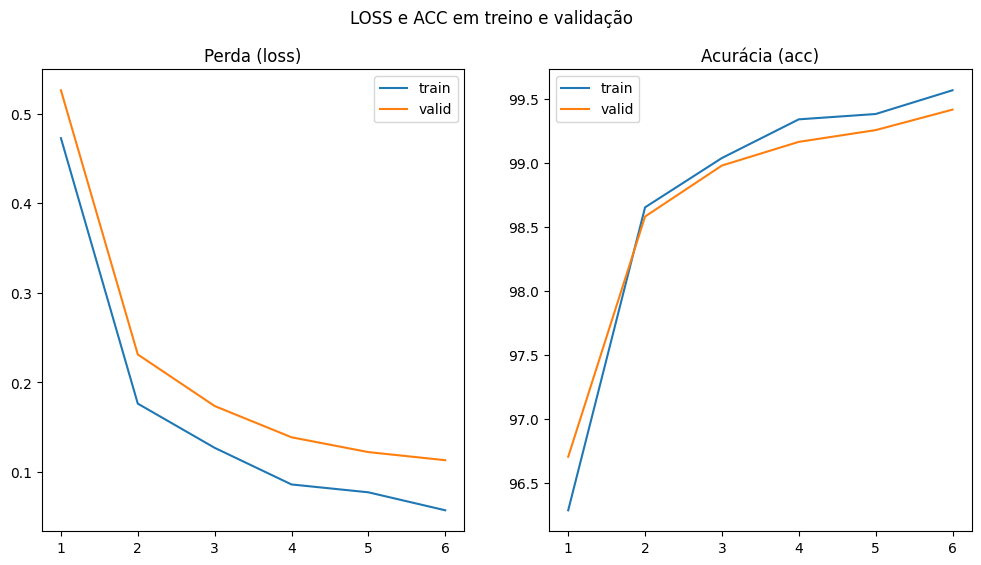

In [72]:
# QUESTAO 3

from matplotlib import pyplot as plt

epochs = list(range(1, 7))

plt.figure('LOSS e ACC em treino e validação', figsize=(12,6))
plt.suptitle('LOSS e ACC em treino e validação')

# LOSS
axis1 = plt.subplot(1,2,1)
plt.plot(epochs, train_loss_list)
plt.plot(epochs, valid_loss_list)
plt.legend(['train', 'valid'])
axis1.set_title('Perda (loss)')

# ACC
axis2 =plt.subplot(1,2,2)
plt.plot(epochs, train_acc_list)
plt.plot(epochs, valid_acc_list)
plt.legend(['train', 'valid'])
axis2.set_title('Acurácia (acc)')


plt.show()

In [73]:
model.eval() # coloca o modelo em modo de avaliação (sem calcular gradientes)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)   # QUESTAO 1
        labels = labels.to(device)   # QUESTAO 1

        # Feed-forward com as imagens de teste
        outputs = model(images)

        # gera predições usando a função max()
        _, predicted = torch.max(outputs.data, 1)

        # Acumula total e corretas
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Acurácia do Modelo em 10k imagens de teste: {round((correct / total) * 100, 3)}")

Acurácia do Modelo em 10k imagens de teste: 99.13
